# Generative Adversarial Networks

> Generative adversarial networks (GANs) are a class of artificial intelligence algorithms used in unsupervised machine learning, implemented by a system of two neural networks contesting with each other in a zero-sum game framework. They were introduced by Ian Goodfellow et al. in 2014. This technique can generate photographs that look at least superficially authentic to human observers, having many realistic characteristics (though in tests people can tell real from generated in many cases). (Wikipedia)

This source code provides a very simple implementation of a GAN (similar to the original implementation of Goodfellow et al. 2014) with Keras on Tensorflow.

First, we download the dataset and normalise the data into the interval `[0, 1]`.

In [0]:
from keras.datasets import mnist
import numpy as np

(X_train, _), (_, _) = mnist.load_data()

# normalise data
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))

We define our network in a simple manner: The generator and discrimnator have an almost symmetrical design, which resembles an inverse autoencoder: The generator takes low-resolution noise as its input and scales it up to the image resolution. The discriminator takes an image as its input and outputs a single binary digit (which decides, whether the image was fake or real).

We use LeakyReLU as the activation functions between the internal layers and tanh for the discrimation layer.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input, MaxoutDense
from keras.optimizers import Adam

img_shape = (X_train.shape[1], X_train.shape[2])
res = X_train.shape[1] * X_train.shape[2]
noise_res = int(resolution / 4)

D = Sequential()
D.add(Flatten(input_shape=img_shape))
D.add(Dense(int(res/2)))
D.add(LeakyReLU())
D.add(Dense(int(res/4)))
D.add(LeakyReLU())
D.add(Dense(int(res/8)))
D.add(LeakyReLU())
D.add(Dense(1, activation='sigmoid'))
D.summary()

optimizer = Adam(0.0002, 0.5)
D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

G = Sequential()
G.add(Dense(int(res/4), input_shape=(noise_res,)))
G.add(LeakyReLU())
G.add(Dense(int(res/2)))
G.add(LeakyReLU())
G.add(Dense(int(res)))
G.add(LeakyReLU())
G.add(MaxoutDense(res))
G.add(Reshape(img_shape))
G.summary()

z = Input(shape=(noise_res,))

D.trainable = False
full_gan = Model(z, D(G(z)))
full_gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

We train in mini-batches. In each epoch, the discriminator is trained with 50% fake and 50% real images. Afterwards, the generator is trained.

In [ ]:
epochs = 30000
batch_size = 32
half_batch_size = int(batch_size / 2)

for epoch in range(epochs):
    # get half the batch from real images
    real_idxs = np.random.randint(X_train.shape[0], size=half_batch_size)
    real_imgs = X_train[real_idxs]
    
    # get other half of generated images
    noise = np.random.normal(size=(half_batch_size, noise_res))
    fake_imgs = G.predict(noise)
    
    # train discriminator
    rloss = D.train_on_batch(real_imgs, np.ones(half_batch_size))
    floss = D.train_on_batch(fake_imgs, np.zeros(half_batch_size))
    dloss = 0.5 * np.add(rloss, floss)

    # train generator
    # first, generate images and classify them via discriminator
    noise = np.random.normal(size=(batch_size, noise_res))
    gloss = full_gan.train_on_batch(noise, np.ones(batch_size,))
    
    if epoch % 100 == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, dloss[0], 100*dloss[1], gloss[0]))

Lastly, we generate and visualise some images.

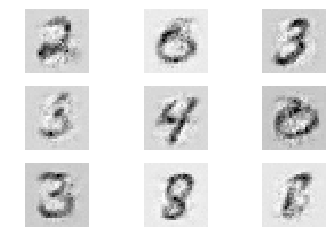

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 9
noise = np.random.normal(size=(n, noise_res))
imgs = G.predict(noise)

fig = plt.figure()
for i in range(n):
    ax = fig.add_subplot(3,3,i+1)
    ax.axis('off')
    ax.imshow(imgs[i])